In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [17]:
# 데이터 로드
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"
df = pd.read_csv(url)

display(df.head())

'''
# 범주형 인코딩 -> 값이 문자열일 때만 사용
df['Outcome'] = LabelEncoder().fit_transform(df['Outcome'])
'''

# 입력과 타겟 분리
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values.astype(np.float32)

# 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)



# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Shape 확인
X_train.shape, y_train.shape, X_test.shape, y_test.shape

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


((614, 8), (614,), (154, 8), (154,))

# 파이토치형 Tensor로 변환

In [11]:
# TensorDataset으로 래핑
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape

(torch.Size([614, 8]),
 torch.Size([614]),
 torch.Size([154, 8]),
 torch.Size([154]))

In [12]:
# 분류 모델 정의
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid() #이중 분류에서는 Sigmoid 활성화, 회귀에서는 x
        )

    def forward(self, x):
        return self.model(x)

model = ClassificationModel()

# 손실 함수 및 최적화 기법 정의
criterion = nn.BCEWithLogitsLoss() #회귀는 MSELoss(), 다중 분류는 CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        labels = labels.view(-1, 1).float() # 모델의 출력값과 정답 라벨의 차원을 맞춰줌
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_loader))

    # Evaluate on test data, 회귀에서 수정해야할 부분
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6550, Accuracy: 64.29%
Epoch 2/20, Loss: 0.6514, Accuracy: 64.29%
Epoch 3/20, Loss: 0.6501, Accuracy: 64.29%
Epoch 4/20, Loss: 0.6563, Accuracy: 64.29%
Epoch 5/20, Loss: 0.6503, Accuracy: 64.29%
Epoch 6/20, Loss: 0.6510, Accuracy: 64.29%
Epoch 7/20, Loss: 0.6443, Accuracy: 64.29%
Epoch 8/20, Loss: 0.6488, Accuracy: 64.29%
Epoch 9/20, Loss: 0.6473, Accuracy: 64.29%
Epoch 10/20, Loss: 0.6476, Accuracy: 64.29%
Epoch 11/20, Loss: 0.6451, Accuracy: 64.29%
Epoch 12/20, Loss: 0.6468, Accuracy: 64.29%
Epoch 13/20, Loss: 0.6470, Accuracy: 64.29%
Epoch 14/20, Loss: 0.6500, Accuracy: 64.29%
Epoch 15/20, Loss: 0.6432, Accuracy: 64.29%
Epoch 16/20, Loss: 0.6446, Accuracy: 64.29%
Epoch 17/20, Loss: 0.6440, Accuracy: 64.29%
Epoch 18/20, Loss: 0.6441, Accuracy: 64.29%
Epoch 19/20, Loss: 0.6477, Accuracy: 64.29%
Epoch 20/20, Loss: 0.6508, Accuracy: 64.29%
Training complete.


# 모델 평가

In [15]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[99  0]
 [55  0]]
F1 Score: 0.50
Precision: 0.41
Recall: 0.64
Specificity: 0.50


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


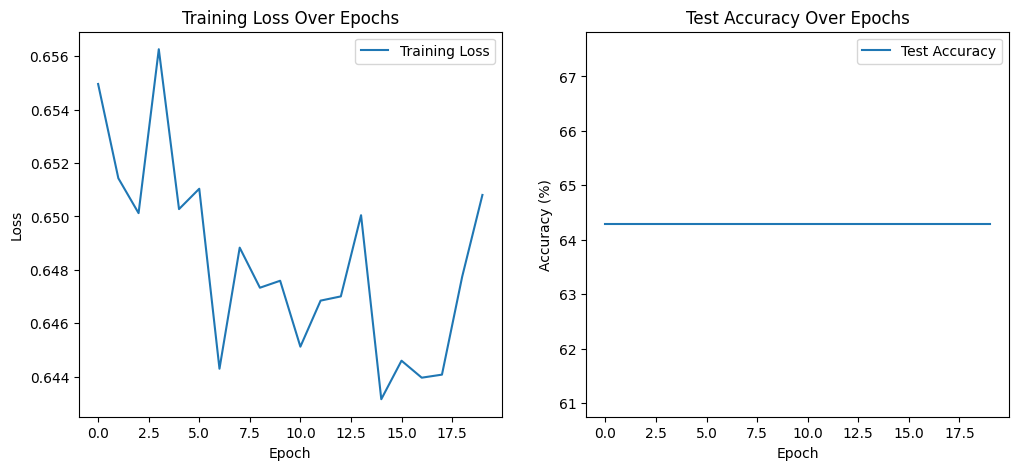

In [16]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()